# Tutorial 1: Control Óptimo para Estados Discretos

---
# Objetivos del Tutorial

En este tutorial, implementaremos una tarea de control binario: un Proceso de Decisión de Markov Parcialmente Observable (POMDP, por sus siglas en inglés, *Partially Observed Markov Decision Process*) que describe pescar. El agente (tú) busca recompensa entre dos sitios de pesca sin poder observar directamente donde está el cardúmen de peces. Esto hace que el mundo sea un Modelo Oculto de Markov. Basado en donde y cuando atrapes pescados, estarás siempre actualizando tus creencias sobre la posición de los peces (es decir, la probabilidad a posteriori de los peces dadas las observaciones pasadas). Deberías poder controlar tu posición para maximizar la cantidad de peces mientras minimizas el costo de cambiar de lado.

Ya has aprendido acerca de dinámica estocástica, estados latentes (ocultos) y mediciones. Ahora los introduciremos a nuevos conceptos de **control, utilidad y política**

---
## Configuración  



In [25]:
# Imports

import numpy as np
import scipy
from scipy.linalg import inv
from math import isclose
import matplotlib.pyplot as plt

In [26]:
# @title Ajustes de Figura
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets
from IPython.display import HTML
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [27]:
# @title Funciones de Graficado

def plot_fish(fish_state, ax=None, show=True):
  """
  Plot the fish dynamics (states across time)
  """
  T = len(fish_state)

  offset = 3

  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))

  x = np.arange(0, T, 1)
  y = offset * (fish_state*2 - 1)

  ax.plot(y, color='cornflowerblue', markersize=10, linewidth=3.0, zorder=0)
  ax.fill_between(x, y, color='cornflowerblue', alpha=.3)

  ax.set_xlabel('time')
  ax.set_ylabel('fish location')

  ax.set_xlim([0, T])
  ax.set_xticks([])
  ax.xaxis.set_label_coords(1.05, .54)

  ax.set_ylim([-(offset+.5), offset+.5])
  ax.set_yticks([-offset, offset])
  ax.set_yticklabels(['left', 'right'])

  ax.spines['bottom'].set_position('center')
  if show:
    plt.show()


def plot_measurement(measurement, ax=None, show=True):
  """
  Plot the measurements
  """
  T = len(measurement)

  rel_pos = 3
  red_y = []
  blue_y = []
  for idx, value in enumerate(measurement):
    if value == 0:
      blue_y.append([idx, -rel_pos])
    else:
      red_y.append([idx, rel_pos])

  red_y = np.asarray(red_y)
  blue_y = np.asarray(blue_y)

  if not ax:
    fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))

  if len(red_y) > 0:
    ax.plot(red_y[:, 0], red_y[:, 1], '*', markersize=8, color='crimson')

  if len(blue_y) > 0:
    ax.plot(blue_y[:, 0], blue_y[:, 1], '*', markersize=8, color='royalblue')

  ax.set_xlabel('time', fontsize=18)
  ax.set_ylabel('Caught fish?')

  ax.set_xlim([0, T])
  ax.set_xticks([])
  ax.xaxis.set_label_coords(1.05, .54)

  ax.set_ylim([-rel_pos - .5, rel_pos + .5])
  ax.set_yticks([-rel_pos, rel_pos])
  ax.set_yticklabels(['no', 'yes!'])

  ax.spines['bottom'].set_position('center')
  if show:
    plt.show()


def plot_act_loc(loc, act, ax_loc=None, show=True):
  """
  Plot the action and location of T time points
  """
  T = len(act)

  if not ax_loc:
    fig, ax_loc = plt.subplots(1, 1, figsize=(12, 2.5))

  loc = loc*2 - 1
  act_down = []
  act_up = []
  for t in range(1, T):
    if loc[t-1] == -1 and loc[t] == 1:
      act_up.append([t - 0.5, 0])
    if loc[t-1] == 1 and loc[t] == -1:
      act_down.append([t - 0.5, 0])

  act_down = np.array(act_down)
  act_up = np.array(act_up)

  ax_loc.plot(loc, 'g.-', markersize=8, linewidth=5)

  if len(act_down) > 0:
    ax_loc.plot(act_down[:, 0], act_down[:, 1], 'rv', markersize=18, zorder=10, label='switch')

  if len(act_up) > 0:
    ax_loc.plot(act_up[:, 0], act_up[:, 1], 'r^', markersize=18, zorder=10)

  ax_loc.set_xlabel('time')
  ax_loc.set_ylabel('Your state')

  ax_loc.set_xlim([0, T])
  ax_loc.set_xticks([])
  ax_loc.xaxis.set_label_coords(1.05, .54)

  if len(act_down) > 0:
    ax_loc.legend(loc="upper right")
  elif len(act_down) == 0 and len(act_up) > 0:
    ax_loc.plot(act_up[:, 0], act_up[:, 1], 'r^', markersize=18, zorder=10, label='switch')
    ax_loc.legend(loc="upper right")

  ax_loc.set_ylim([-1.1, 1.1])
  ax_loc.set_yticks([-1, 1])

  ax_loc.tick_params(axis='both', which='major')
  ax_loc.set_yticklabels(['left', 'right'])

  ax_loc.spines['bottom'].set_position('center')

  if show:
    plt.show()


def plot_belief(belief, ax1=None, choose_policy=None, show=True):
  """
  Plot the belief dynamics of T time points
  """

  T = belief.shape[1]

  if not ax1:
      fig, ax1 = plt.subplots(1, 1, figsize=(12, 2.5))

  ax1.plot(belief[1, :], color='midnightblue', markersize=10, linewidth=3.0)

  ax1.set_xlabel('time')
  ax1.set_ylabel('Belief (right)')

  ax1.set_xlim([0, T])
  ax1.set_xticks([])
  ax1.xaxis.set_label_coords(1.05, 0.05)

  ax1.set_yticks([0, 1])
  ax1.set_ylim([0, 1.1])

  labels = [item.get_text() for item in ax1.get_yticklabels()]
  ax1.set_yticklabels(['    0', '    1'])

  """
  if choose_policy == "threshold":
    ax2 = ax1.twinx()
    ax2.plot(time_range, threshold * np.ones(time_range.shape), 'r--')
    ax2.plot(time_range, (1 - threshold) * np.ones(time_range.shape), 'c--')
    ax2.set_yticks([threshold, 1 - threshold])
    ax2.set_ylim([0, 1.1])
    ax2.tick_params(axis='both', which='major', labelsize=18)
    labels = [item.get_text() for item in ax2.get_yticklabels()]
    labels[0] = 'threshold to switch \n from left to right'
    labels[-1] = 'threshold to switch \n from right to left'
    ax2.set_yticklabels(labels)
  """
  if show:
    plt.show()


def plot_dynamics(belief, loc, act, meas, fish_state, choose_policy):
  """
  Plot the dynamics of T time points
  """
  if choose_policy == 'threshold':
    fig, [ax0, ax_bel, ax_loc, ax1] = plt.subplots(4, 1, figsize=(12, 9))
    plot_fish(fish_state, ax=ax0, show=False)
    plot_belief(belief, ax1=ax_bel, show=False)
    plot_measurement(meas, ax=ax1, show=False)
    plot_act_loc(loc, act, ax_loc=ax_loc)
  else:
    fig, [ax0, ax_bel, ax1] = plt.subplots(3, 1, figsize=(12, 7))
    plot_fish(fish_state, ax=ax0, show=False)
    plot_belief(belief, ax1=ax_bel, show=False)
    plot_measurement(meas, ax=ax1, show=False)

  plt.tight_layout()
  plt.show()


def belief_histogram(belief, bins=100):
  """
  Plot the histogram of belief states
  """
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))
  ax.hist(belief, bins)
  ax.set_xlabel('belief', fontsize=18)
  ax.set_ylabel('count', fontsize=18)
  plt.show()


def plot_value_threshold(threshold_array, value_array):
  """
  Helper function to plot the value function and threshold
  """
  yrange = np.max(value_array) - np.min(value_array)
  star_loc = np.argmax(value_array)

  fig_, ax = plt.subplots(1, 1, figsize=(8, 6))
  ax.plot(threshold_array, value_array, 'b')
  ax.vlines(threshold_array[star_loc],
            min(value_array) - yrange * .1, max(value_array),
            colors='red', ls='--')
  ax.plot(threshold_array[star_loc],
          value_array[star_loc],
          '*', color='crimson',
          markersize=20)

  ax.set_ylim([np.min(value_array) - yrange * .1,
               np.max(value_array) + yrange * .1])
  ax.set_title(f'threshold vs value with switching cost c = {cost_sw:.2f}',
               fontsize=20)
  ax.set_xlabel('threshold', fontsize=16)
  ax.set_ylabel('value', fontsize=16)
  plt.show()

In [28]:
# @title Funciones de ayuda

# To generate a binomial with fixed "noise",
# we generate a fist sequence of T numbers uniformly at random
# this sequence can be changed later with different size T
np.random.seed(42)
init_T = 100
rnd_tele = np.random.uniform(0, 1, init_T)
rnd_high_rwd = np.random.uniform(0, 1, init_T)
rnd_low_rwd = np.random.uniform(0, 1, init_T)


def get_randomness(T):

  global rnd_tele
  global rnd_high_rwd
  global rnd_low_rwd

  rnd_tele = np.random.uniform(0, 1, T)
  rnd_high_rwd = np.random.uniform(0, 1, T)
  rnd_low_rwd = np.random.uniform(0, 1, T)


def binomial_tele(p, T):
  if len(rnd_tele) < T:
    get_randomness(T)

  return np.array([1 if p > rnd_tele[i] else 0 for i in range(T)])


# Need a better name
def getRandomness(p, T):

  global rnd_tele
  global rnd_high_rwd
  global rnd_low_rwd

  rnd_tele = np.random.uniform(0, 1, T)
  rnd_high_rwd = np.random.uniform(0, 1, T)
  rnd_low_rwd = np.random.uniform(0, 1, T)

  return [binomial_tele(p, T), rnd_high_rwd, rnd_low_rwd]


class ExcerciseError(AssertionError):
  pass


class binaryHMM():

  def __init__(self, params, T, fish_initial=0, loc_initial=0):
    self.params = params
    self.fish_initial = fish_initial
    self.loc_initial = loc_initial
    self.T = T

  def fish_dynamics(self):
    """
    fish state dynamics according to telegraph process

    Returns:
      fish_state (numpy array of int)
    """

    p_stay, _, _, _ = self.params
    fish_state = np.zeros(self.T, int)  # 0: left side and 1: right side

    # initialization
    fish_state[0] = self.fish_initial
    tele_operations = binomial_tele(p_stay, self.T) # 0: switch and 1: stay

    for t in range(1, self.T):
      # we use logical operation NOT XOR to determine the next state
      fish_state[t] = int(not(fish_state[t-1] ^ tele_operations[t]))

    return fish_state

  def generate_process_lazy(self):
    """
    fish dynamics and rewards if you always stay in the initial location
    without changing sides

    Returns:
      fish_state (numpy array of int): locations of the fish
      loc (numpy array of int): left or right site, 0 for left, and 1 for right
      rwd (numpy array of binary): whether a fish was catched or not
    """

    _, p_low_rwd, p_high_rwd, _ = self.params

    fish_state = self.fish_dynamics()
    rwd = np.zeros(self.T, int)  # 0: no food, 1: get food

    for t in range(0, self.T):
      # new measurement
      if fish_state[t] != self.loc_initial:
        rwd[t] = 1 if p_low_rwd > rnd_low_rwd[t] else 0
      else:
        rwd[t] = 1 if p_high_rwd > rnd_high_rwd[t] else 0

      # rwd[t] = binomial(1, p_rwd_vector[(fish_state[t] == loc[t]) * 1])
    return fish_state, self.loc_initial*np.ones(self.T), rwd


class binaryHMM_belief(binaryHMM):

  def __init__(self, params, T,
               fish_initial=0, loc_initial=1,
               choose_policy='threshold'):

      binaryHMM.__init__(self, params, T, fish_initial, loc_initial)
      self.choose_policy = choose_policy

  def generate_process(self):
    """
    fish dynamics and measurements based on the chosen policy

    Returns:
      belief (numpy array of float): belief on the states of the two sites
      act (numpy array of string): actions over time
      loc (numpy array of int): left or right site
      measurement (numpy array of binary): whether a reward is obtained
      fish_state (numpy array of int): fish locations
    """

    p_stay, low_rew_p, high_rew_p, threshold = self.params
    fish_state = self.fish_dynamics()     # 0: left side; 1: right side
    loc = np.zeros(self.T, int)                # 0: left side, 1: right side
    measurement = np.zeros(self.T, int)        # 0: no food, 1: get food
    act = np.empty(self.T, dtype='object')     # "stay", or "switch"
    belief = np.zeros((2, self.T), float)      # the probability that the fish is on the left (1st element)
                                          # or on the right (2nd element),
                                          # the beliefs on the two boxes sum up to be 1

    rew_prob = np.array([low_rew_p, high_rew_p])

    # initialization
    loc[0] = self.loc_initial
    measurement[0] = 0
    belief_0 = np.random.random(1)[0]
    belief[:, 0] = np.array([belief_0, 1 - belief_0])
    act[0] = self.policy(threshold, belief[:, 0], loc[0])

    for t in range(1, self.T):
      if act[t - 1] == "stay":
          loc[t] = loc[t - 1]
      else:
          loc[t] = int(not(loc[t - 1] ^ 0))

      # new measurement
      # measurement[t] = binomial(1, rew_prob[(fish_state[t] == loc[t]) * 1])
      if fish_state[t] != loc[t]:
          measurement[t] = 1 if low_rew_p > rnd_low_rwd[t] else 0
      else:
          measurement[t] = 1 if high_rew_p > rnd_high_rwd[t] else 0

      belief[0, t] = self.belief_update(belief[0, t - 1] , loc[t],
                                        measurement[t], p_stay,
                                        high_rew_p, low_rew_p)
      belief[1, t] = 1 - belief[0, t]

      act[t] = self.policy(threshold, belief[:, t], loc[t])

    return belief, loc, act, measurement, fish_state

  def policy(self, threshold, belief, loc):
    """
    chooses policy based on whether it is lazy policy
        or a threshold-based policy

    Args:
      threshold (float): the threshold of belief on the current site,
          when the belief is lower than the threshold, switch side
      belief (numpy array of float): the belief on the two sites
      loc (int) : the location of the agent

    Returns:
      act (string): "stay" or "switch"
    """
    if self.choose_policy == "threshold":
      act = policy_threshold(threshold, belief, loc)
    if self.choose_policy == "lazy":
      act = policy_lazy(belief, loc)

    return act

  def belief_update(self, belief_past, loc, measurement, p_stay,
                    high_rew_p, low_rew_p):
    """
    using PAST belief on the LEFT box, CURRENT location and
        and measurement to update belief
    """
    rew_prob_matrix = np.array([[1 - high_rew_p, high_rew_p],
                                [1 - low_rew_p, low_rew_p]])

    # update belief posterior, p(s[t] | measurement(0-t), act(0-t-1))
    belief_0 = (belief_past * p_stay  + (1 - belief_past) * (1 - p_stay)) *\
                            rew_prob_matrix[(loc + 1) // 2, measurement]
    belief_1 = ((1 - belief_past) * p_stay + belief_past * (1 - p_stay)) *\
                            rew_prob_matrix[1-(loc + 1) // 2, measurement]

    belief_0 = belief_0 / (belief_0 + belief_1)

    return belief_0


def policy_lazy(belief, loc):
  """
  This function is a lazy policy where stay is also taken
  """
  act = "stay"

  return act


def test_policy_threshold():
  well_done = True
  for loc in [-1, 1]:
    threshold = 0.4
    belief = np.array([.2, .3])
    if policy_threshold(threshold, belief, loc) != "switch":
      raise ExcerciseError("'policy_threshold' function is not correctly implemented!")
  for loc in [1, -1]:
    threshold = 0.6
    belief = np.array([.7, .8])
    if policy_threshold(threshold, belief, loc) != "stay":
      raise ExcerciseError("'policy_threshold' function is not correctly implemented!")
  print("Well Done!")


def test_policy_threshold():
  for loc in [-1, 1]:
    threshold = 0.4
    belief = np.ones(2) * (threshold + 0.1)
    belief[(loc + 1) // 2] = threshold - 0.1

    if policy_threshold(threshold, belief, loc) != "switch":
      raise ExcerciseError("'policy_threshold' function is not correctly implemented!")
    if policy_threshold(threshold, belief, -1 * loc) != "stay":
      raise ExcerciseError("'policy_threshold' function is not correctly implemented!")

  print("Well Done!")


def test_value_function():
  measurement = np.array([0, 0, 0, 1, 0, 0, 0, 0, 1, 1])
  act = np.array(["switch", "stay", "switch", "stay", "stay",
                  "stay", "switch", "switch", "stay", "stay"])
  cost_sw = .5
  if not isclose(get_value(measurement, act, cost_sw), .1):
    raise ExcerciseError("'value_function' function is not correctly implemented!")
  print("Well Done!")

---
# Sección 1: Las Dinámicas de la Pesca

Hay dos posiciones para los peces y para vos (Izquierda y Derecha). Si estás en el mismo lado que los peces, atraparás más, con probabilidad $q_{\rm alta}$ en cada paso de tiempo discreto. Caso contrario, todavía existe la probabilidad de que atrapes peces, per con la probabilidad reducida $q_{\rm baja}$. Cada pez vale 1 "punto".

La posición de los peces $s^{\rm peces}$ es latente. La única información que obtienes acerca de la posición de los peces es cuando atrapas a uno. Secretamente en cada paso de tiempo, los peces pueden cambiar de lado con una cierta probabilidad $p_{\rm cambian} = 1 - p_{\rm quedan}$.

Tú estás en control de tu propia posición. Puedes quedarte en el lado actual sin costo, o cambiar al otro lado e incurrir un costo de acción $C$ (de nuevo, en unidades de peces).

Tu seleccionas controles o acciones siguiendo una **política**. Esto define que hacer en cualquier situación. Aqui la situación está especificada por tu posición y tu creencia $b_t$ (*b* de *belief*) acerca de la posición de los peces. Para control óptimo, asumimos que esta creencia es la probabilidad a posteriori sobre la posición actual de los peces, dadas todas las mediciones anteriores. Solo necesitamos un número para esto, así que escribimos:

$$b_t = p(s^{\rm peces}_t = {\rm Derecha}\  |\  m_{0:t}, a_{0:t-1})$$

donde $m$ son las mediciones, y $a$ son los controles o acciones (quedarse o cambiar de lado).

Finalmente, parametrizaremos la política por un simple umbral en las creencias (¡que será óptimo si elijes el umbral adecuado!). Cuando tu creencia de que los peces están en tu posición actual está debajo de un umbral $\theta$, cambias de lado.

Tus **objetivos totales** son:
1. Medir, cuando los peces son atrapados, si el cardúmen de peces se movió o no.
2. Para peces que se movieron, graficar su dinámica y tus creencias acerca de ella basado en tus mediciones/observaciones.
3. Computar el valor para una dada política de control.
4. Encontrar la política óptima para controlar tu posición.

## Demo Interactiva 1: Examinando la dinámica de peces

En esta demo, miraremos la dinámica de los peces moviendose de lado a lado. Usaremos la clase de ayuda `binaryHMM`, implementada en la próxima celda. Por favor tomate un tiempo para estudiar esta clase y sus métodos. Luego verás una demo donde puedes cambiar la probabilidad de cambiar de estado (es decir, de lado) y examinar la dinámica resultante de los peces.

In [38]:
# @markdown Execute this cell to enable the demo.
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(p_stay=widgets.FloatSlider(.9, description="stay_prob", min=0., max=1., step=0.01))

def update_ex_1(p_stay):
  """
    T: Length of timeline
    p_stay: probability that the fish do not swim to the other side at time t
  """
  params = [p_stay, _, _, _]

  # initial condition: fish [fish_initial] start at the left location (-1)
  binaryHMM_test = binaryHMM(params=params, fish_initial=1, T=100)

  fish_state = binaryHMM_test.fish_dynamics()
  plot_fish(fish_state)

plt.show()

interactive(children=(FloatSlider(value=0.9, description='stay_prob', max=1.0, step=0.01), Output()), _dom_cla…

---
# Sección 2: Atrapando pescado

## Demo Interactivo 2: Atrapando pescado

Ahora pon $p_{\rm quedan} = 1$ para que el estado de los peces quede fijo, y podemos observar directamente las chances de atrapar peces en cada lado (el mismo y el opuesto). La variable `fish_initial` indica el lado inicial de los peces, y `loc_initial` indica tu posición inicial. Ambos toman un valor de $-1$ para izquierda y $1$ para derecha.

**Instrucciones:**
1. fija las dos posiciones (`fish_initial` y `loc_initial`) para que sean las _mismas_, y mide cuando atrapas peces.
2. fija las dos posiciones (`fish_initial` y `loc_initial`) para que sean _diferentes_, y mide cuando atrapas peces.
3. compara visualmente las mediciones de 1 y 2.
4. Finalmente, puedes jugar con los deslizadores de `high_rew_p` (probabilidad de recompensa alta) y `low_rew_p` (probabilidad de recompensa baja) para ver como afecta los resultados.

In [39]:
# @markdown Execute this cell to enable the demo.
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(locs=widgets.RadioButtons(options=['same location', 'different locations'],
                                            description='Fish and agent:',
                                            disabled=False,
                                            layout={'width': 'max-content'}),
                  p_low_rwd=widgets.FloatSlider(.1, description="low_rew_prob:",
                                                min=0., max=1.),
                  p_high_rwd=widgets.FloatSlider(.9, description="high_rew_prob:",
                                                 min=0., max=1.))

def update_ex_2(locs, p_low_rwd, p_high_rwd):
  """
    p_stay: probability of fish staying at current side at time t
    p_low_rwd: probability of catching fish when you're NOT on the side where the fish are swimming
    p_high_rwd: probability of catching fish when you're on the side where the fish are swimming
    fish_initial: initial side of fish (-1 left, 1 right)
    agent_initial: initial side of the agent (YOU!) (-1 left, 1 right)
  """
  p_stay = 1
  params = [p_stay, p_low_rwd, p_high_rwd, _]

  # initial condition for fish [fish_initial] and you [loc_initial]
  if locs == 'same location':
    binaryHMM_test = binaryHMM(params, fish_initial=0, loc_initial=0, T=100)
  else:
    binaryHMM_test = binaryHMM(params, fish_initial=1, loc_initial=0, T=100)

  fish_state, loc, measurement = binaryHMM_test.generate_process_lazy()
  plot_measurement(measurement)

interactive(children=(RadioButtons(description='Fish and agent:', layout=Layout(width='max-content'), options=…

---
# Sección 3: Dinámica y distribuciones de la creencia

Hemos provisto una clase para la tarea binaria, con el agente siempre manteniendose en un mismo lado siguiendo una política perezosa `def policy_lazy(belief, loc)` que también hemos provisto. Ahora en este ejercicio, extenderás el módulo para general dinámicas reales, incluyendo crencias y un agente que se mueve. Con los datos generados, veremos como las creencias cambian con el tiempo y que tán seguido tenemos distintas creencias.

Por conveniencia, tu creencia en el momento *t* es en realidad un vector de 2 dimensiones. El primer elemento es la creencia de que los peces están en la izquierda, y el segundo la creencia que los peces están en la derecha. En cada instante, estos elementos sumarán a $1$.

Primero miraremos las dinámicas con la política perezosa, y luego exploraremos el caso con una política basada en un umbral.

Corre las celdas debajo para configurar la política perezosa.


In [40]:
# @markdown Execute this cell to enable the demo.
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(p_stay=widgets.FloatSlider(.96, description="stay_prob",
                                             min=.8, max=1., step=.01),
                  p_low_rwd=widgets.FloatSlider(.1, description="low_rew_prob",
                                                min=0., max=1., step=.01),
                  p_high_rwd=widgets.FloatSlider(.3, description="high_rew_prob",
                                                 min=0., max=1., step=.01))

def update_ex_2(p_stay, p_low_rwd, p_high_rwd):
  """
    T: Length of timeline
    p_stay: probability of fish staying at current side at time t
    p_high_rwd: probability of catching fish when you're on the side where the fish are swimming
    p_low_rwd: probability of catching fish when you're NOT on the side where the fish are swimming
    fish_initial: initial side of fish (0 left, 1 right)
    agent_initial: initial side of the agent (YOU!) (0 left, 1 right)
    threshold: threshold of belief below which the action is switching
  """
  threshold = 0.2
  params = [p_stay, p_low_rwd, p_high_rwd, threshold]

  binaryHMM_test = binaryHMM_belief(params, choose_policy="lazy",
                                    fish_initial=0, loc_initial=0, T=100)

  belief, loc, act, measurement, fish_state = binaryHMM_test.generate_process()
  plot_dynamics(belief, loc, act, measurement, fish_state,
                binaryHMM_test.choose_policy)

interactive(children=(FloatSlider(value=0.96, description='stay_prob', max=1.0, min=0.8, step=0.01), FloatSlid…

## Demo Interactivo 3: Dinámicas de la tarea dada una política **perezosa**

El parametro `choose_policy` para seleccionar la política puede tener el valor del string "*lazy*" (perezoso) o "*threshold*" (umbral). En el siguiente ejemplo, usaremos la política perezosa.

**Instrucciones:**
* Con la clase definida arriba, hemos creado un objeto de tipo `binaryHMM_belief` dados los parametros de la dinámica, *params*, y un parámetro para la política
* Ejecuta la dinámica y explica la serie temporal de las creencias que vés.



---
# Sección 4: Implementando política con umbral

## Ejercicio de Programación 4: dinámica siguiendo una política **basada en un umbral**.

**Instrucciones:**

* Tienes que programar una nueva política `def policy_threshold(threshold, belief, loc)`. La política toma tres entradas: tus creencias acerca del estado del cardumen, tu posición ("Left" o "Right", si estás a la izquierda o derecha respectivamente), y un _umbral_ sobre las creencias. Cuando tu creencia de que estás en el mismo lado que los peces cae por debajo de este umbral, elijes cambiar de lado; caso contrario, te quedas donde estás.

* Deberías retornar una acción para cada tiempo _t_, que debería tomar el valor (un string) de "stay" o "switch" (para quedarse o cambiar de lado, respectivamente).

* Luego de completar el código para la política basada en un umbral, crea un objeto de tipo `binaryHMM_belief` y cambia el parámetro seleccionador de política para que sea `choose_policy = threshold`.
* Hemos provisto un ejemplo de los parámetros. Deberías jugar con los parámetros para ver como modifica la dinámica.

In [32]:
def policy_threshold(threshold, belief, loc):
  """
  selecciona si cambiar de lado en base a si la creencia en el
    sitio actual cae por debajo de un umbral

  Argumentos:
    threshold (float): el umbral de creencia en la posición actual,
                        cuando la crencia cae por debajo del umbral, cambia de lado
    belief (numpy array de float, 2-dimensional): la creencia sobre los
                                                  dos sitios en un momento dado
    loc (int) : la posición del agente en un dado momento
                -1 para lado izquierdo, 1 para lado derecho

  Retorna:
    act (string): "stay" o "switch" (quedarse o cambiar de lado, respectivamente)
  """
  # Escribe la sentencia if
  if belief[(loc + 1) // 2] <= threshold:
    # acción que toma si está debajo del umbral
    act = "switch"
  else:
    # acción que toma si está arriba del umbral
    act = "stay"

  return act


# Prueba tu función
# test_policy_threshold()

## Demo Interactivo 4: Dinámicas con diferentes umbrales

In [33]:
def update_ex_4(p_stay=.98, threshold=.2, high_rew_p=.4, low_rew_p=.1, T=200):
  """
    p_stay: probabilidad que los peces se queden en el lugar donde están
    high_rew_p: p(atrapar pescado) cuando estás en el mismo lado que el cardumen.
    low_rew_p : p(atrapar pescado) cuando estás en el lado opuesto que el cardumen.
    threshold: umbral de creencia, debajo del cual se hará un cambio de lado.
  """
  params = [T, p_stay, high_rew_p, low_rew_p, threshold]

  #### condiciones iniciales para los peces [fish_initial] y para tí [loc_initial] ####
  binaryHMM_test = binaryHMM_belief(params, fish_initial=-1, loc_initial=-1,
                                    choose_policy="threshold")

  belief, loc, act, measurement, fish_state = binaryHMM_test.generate_process()
  plot_dynamics(belief, loc, act, measurement,
                fish_state, binaryHMM_test.choose_policy)

In [41]:
# @markdown Execute this cell to enable the demo.
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(threshold=widgets.FloatSlider(.2, description="threshold", min=0., max=1., step=.01),
                  new_seed=widgets.ToggleButtons(options=['Reusing', 'Refreshing'],
                                                  description='Random seed:',
                                                  disabled=False,
                                                  button_style='', # 'success', 'info', 'warning', 'danger' or '',
                                                  icons=['check'] * 2
                                                  ))
def update_ex_4(threshold, new_seed):
  """
    p_stay: probability fish stay
    high_rew_p: p(catch fish) when you're on their side
    low_rew_p : p(catch fish) when you're on other side
    threshold: threshold of belief below which switching is taken

  """
  if new_seed == "Refreshing":
    get_randomness(T=100)

  stay_prob=.95
  high_rew_p=.3
  low_rew_p=.1

  params = [stay_prob, high_rew_p, low_rew_p, threshold]

  # initial condition for fish [fish_initial] and you [loc_initial]
  binaryHMM_test = binaryHMM_belief(params, fish_initial=0, loc_initial=0, choose_policy="threshold", T=100)

  belief, loc, act, measurement, fish_state = binaryHMM_test.generate_process()
  plot_dynamics(belief, loc, act, measurement,
                fish_state, binaryHMM_test.choose_policy)
  plt.show()

interactive(children=(FloatSlider(value=0.2, description='threshold', max=1.0, step=0.01), ToggleButtons(descr…

---
# Sección 5: Implementing a value function

## Ejercicio de Programación 5: Implementando una función de Valor

Ahora hemos generado comportamiento para una política parametrizada por un umbral. Aunque parece claro que esto es mejor que ser perezoso (como suele serlo en la vida), queremos saber que tán bueno es. Para eso, calcularemos una _función de valor_. Usaremos este valor para comparar distintas políticas, y maximizar la cantidad de pescado que atrapemos mientras simultaneamente minimizamos nuestro esfuerzo.

Especificamente, el _valor_ aquí es la cantidad total de utilidad esperada por unidad de tiempo.

$$V(\theta) = \frac{1}{T}\left(\sum_t U_s(s_t) + U_a(a_t)\right)$$

donde $U_s(s_t)$ es la utilidad instantanea (recompensa) de esa posición/sitio/estado, y $U_a(a_t)$ es la utilidad (costo negativo, o penalización) para la acción elegida. Aquí, el costo de la acción es 0 si te quedas donde estás, y `cost_sw` si cambias de posición.

Podríamos tomar este promedio matemáticamente sobre las probabilidades de las recomepnsas y acciones. Sin embargo, es más simple y obtendremos los mismos resultados si simplemente promediamos las _verdaderas_ recompensas y costos sobre un periodo prolongado de tiempo, así que es lo que haremos.

**Instrucciones**

* Completa la función `value_function(measurement, act, cost_sw)` que calcula el valor esperado para una secuencia de mediciones, acciones y costos de cambio dados.
* Visualmente encuentra un umbral que dé el mayor valor total. Hemos previsto código para graficar valor versus umbral. El umbral $\theta^*$ que lleve al mayor valor esperado dá la política óptima para controlar donde deberías pescar en cada instante.

In [35]:
def get_value(rewards, actions, cost_sw):
  """
  Args:
    rewards (numpy array of length T): whether a reward is obtained (1) or not (0) at each time step
    actions (numpy array of length T): action, "stay" or "switch", taken at each time step.
    cost_sw (float): the cost of switching to the other location

  Returns:
    value (float): expected utility per unit time
  """
  actions_int = (actions == "switch").astype(int)

  # Calculate the value function
  value = np.sum(rewards - actions_int * cost_sw) / len(rewards)

  return value


# Test your function
# test_value_function()

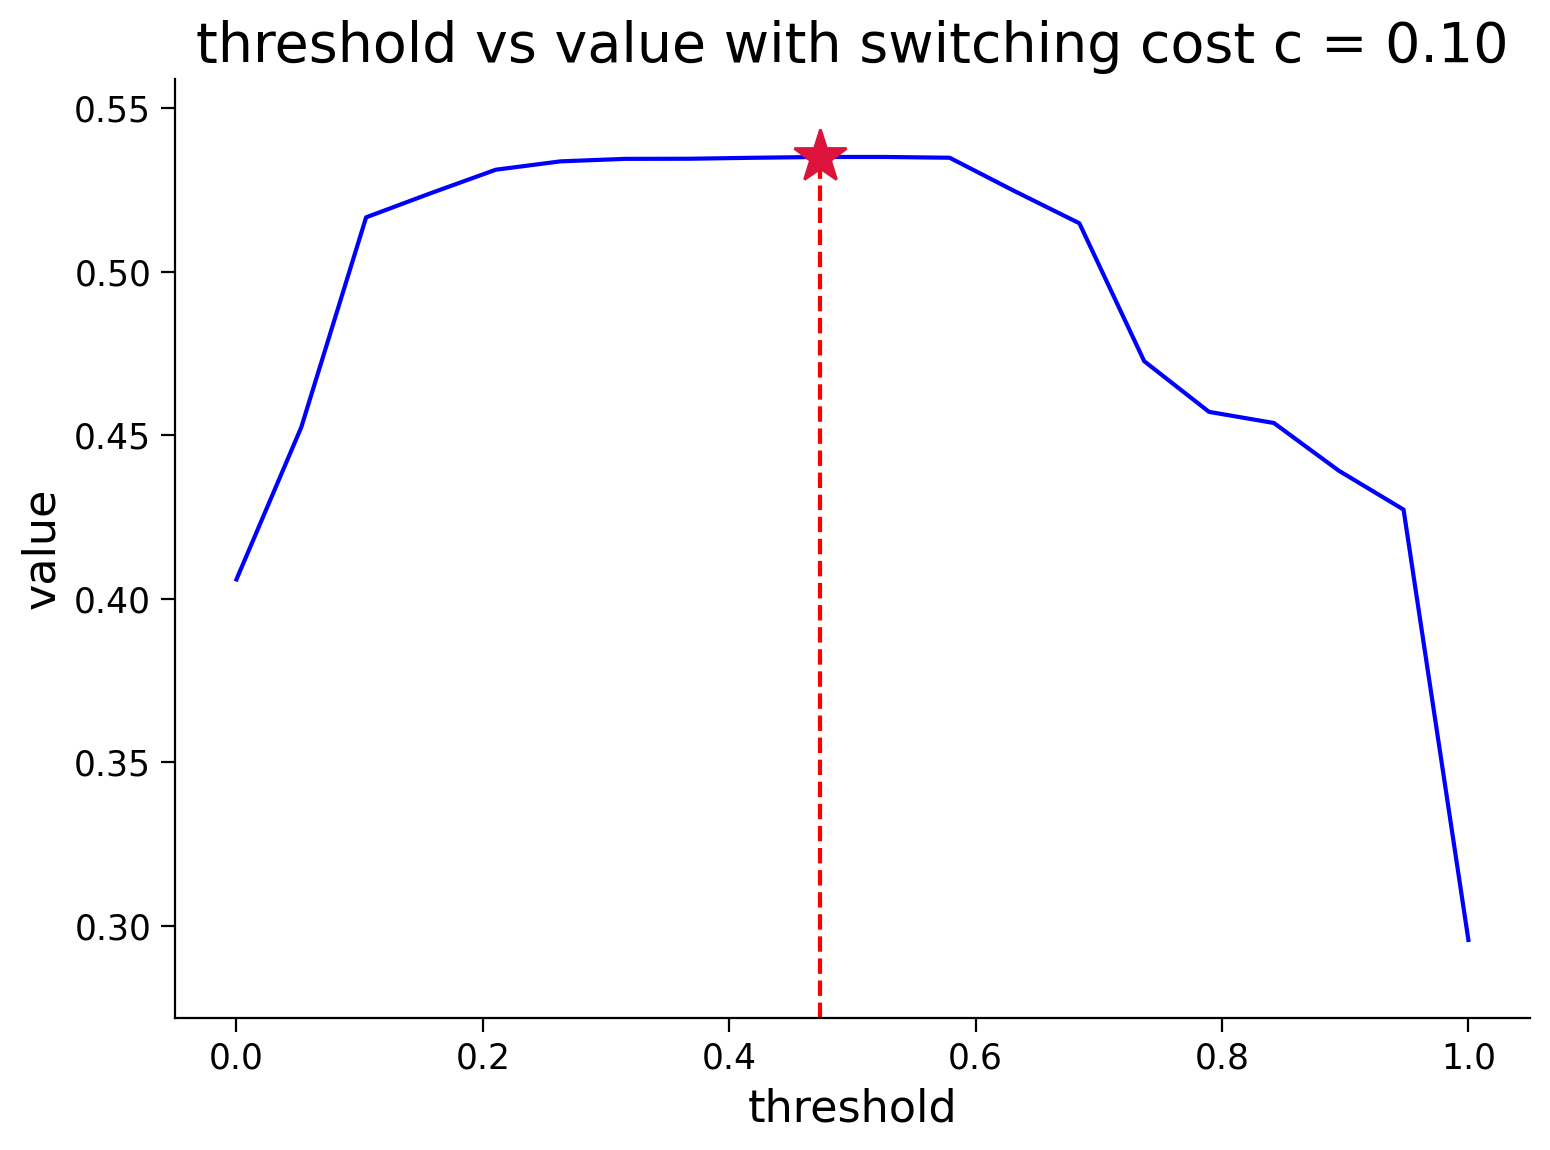

In [42]:

# Set a large time horizon to calculate meaningful statistics
large_time_horizon = 10000
get_randomness(large_time_horizon)

def run_policy(threshold, p_stay, low_rew_p, high_rew_p):
  """
  This function executes the policy (fully parameterized by the threshold) and
  returns two arrays:
    The sequence of actions taken from time 0 to T
    The sequence of rewards obtained from time 0 to T
  """

  params = [p_stay, low_rew_p, high_rew_p, threshold]
  binaryHMM_test = binaryHMM_belief(params, choose_policy="threshold", T=large_time_horizon)
  _, _, actions, rewards, _ = binaryHMM_test.generate_process()
  return actions, rewards


def get_optimal_threshold(p_stay, low_rew_p, high_rew_p, cost_sw):
  """
  Args:
    p_stay (float): probability of fish staying in their current location
    low_rew_p (float): probability of catching fish when you and the fist are in different locations.
    high_rew_p (float): probability of catching fish when you and the fist are in the same location.
    cost_sw (float): the cost of switching to the other location

  Returns:
    value (float): expected utility per unit time
  """

  # Create an array of 20 equally distanced candidate thresholds (min = 0., max=1.):
  threshold_array = np.linspace(0., 1., 20)

  # Using the function get_value() that you coded before and
  # the function run_policy() that we provide, compute the value of your
  # candidate thresholds:

  # Create an array to store the value of each of your candidates:
  value_array = np.zeros(len(threshold_array))

  for i in range(len(threshold_array)):
    actions, rewards = run_policy(threshold_array[i], p_stay, low_rew_p, high_rew_p)
    value_array[i] = get_value(rewards, actions, cost_sw)

  # Return the array of candidate thresholds and their respective values

  return threshold_array, value_array


# Feel free to change these parameters
stay_prob = .9         # Fish stay at current location with probability stay_prob
low_rew_prob = 0.1     # Even if fish are somewhere else, you can catch some fish with probability low_rew_prob
high_rew_prob = 0.7    # When you and the fish are in the same place, you can catch fish with probability high_rew_prob
cost_sw = .1           # When you switch locations, you pay this cost: cost_sw


# Visually determine the threshold that obtains the maximum utility.
# Remember, policies are parameterized by a threshold on beliefs:
# when your belief that the fish are on your current side falls below a threshold 𝜃, you switch to the other side.
threshold_array, value_array = get_optimal_threshold(stay_prob, low_rew_prob, high_rew_prob, cost_sw)
plot_value_threshold(threshold_array, value_array)

---
# Resumen

En este tutorial, has utilizado los Modelos Ocultos de Markov de los cuales aprendiste la clase anterior para descubrir donde estaban los peces, y luego actuaste (cambiaste de posición) para atrapar la mayor cantidad de peces. En particular, encontraste la política óptima para guiar tus acciones.

---
# Bonus

---
## Sección Bonus 1: Distinta tarea, distínta política óptima

### Demo Interactivo Bonus 1

**Instrucciones:**
Luego de graficar el valor versus el umbral, ajustar los diversos parámetros de la tarea utilizando los deslizadores debajo, y observe como el umbral óptimo cambia con:
* el costo de cambiar de lado (`cost_sw`)
* dinámica del cardúmen (`p_switch`)
* probabilidad de atrapar un pescado en cada lado (lado opuesto y mismo lado), `low_rew_p` and `high_rew_p`
Puedes explicar por que el umbral óptimo cambia de esa manera con esos parámetros?

EXPLIQUE la razón de los cambios en el umbral óptimo cuando:
* reduzco el costo de cambiar de lado
* acelero la dinámica del cardúmen (cambian de lado más seguido)
* menos peces (baja mi probabilidad de atrapar pescados)

Notar que puede requerir de simulaciones largas para ver cambios sutiles en los valores de las diferentes política, así que busca para tendencias grandes primero.




In [45]:
# @markdown Make sure you execute this cell to enable the widget!
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(p_stay=widgets.FloatSlider(.95, description="p(stay)",
                                             min=0., max=1., step = 0.1),
                  p_high_rwd=widgets.FloatSlider(.4, description="p(high_rwd)",
                                                 min=0., max=1.),
                  p_low_rwd=widgets.FloatSlider(.1, description="p(low_rwd)",
                                                min=0., max=1.),
                  cost_sw=widgets.FloatSlider(.2, description="switching cost",
                                              min=0., max=1., step=.01))


def update_ex_bonus(p_stay, p_high_rwd, p_low_rwd, cost_sw):
  """
    p_stay: probability fish stay
    high_rew_p: p(catch fish) when you're on their side
    low_rew_p : p(catch fish) when you're on other side
    cost_sw: switching cost
  """

  # Set a large time horizon to calculate meaningful statistics
  large_time_horizon = 10000
  get_randomness(large_time_horizon)

  threshold_array, value_array = get_optimal_threshold(p_stay,
                                                       p_low_rwd,
                                                       p_high_rwd,
                                                       cost_sw)
  plot_value_threshold(threshold_array, value_array)

interactive(children=(FloatSlider(value=0.95, description='p(stay)', max=1.0), FloatSlider(value=0.4, descript…